In [2]:
%pylab inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [3]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return (np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [4]:
data = pd.read_csv('HW_DATA.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


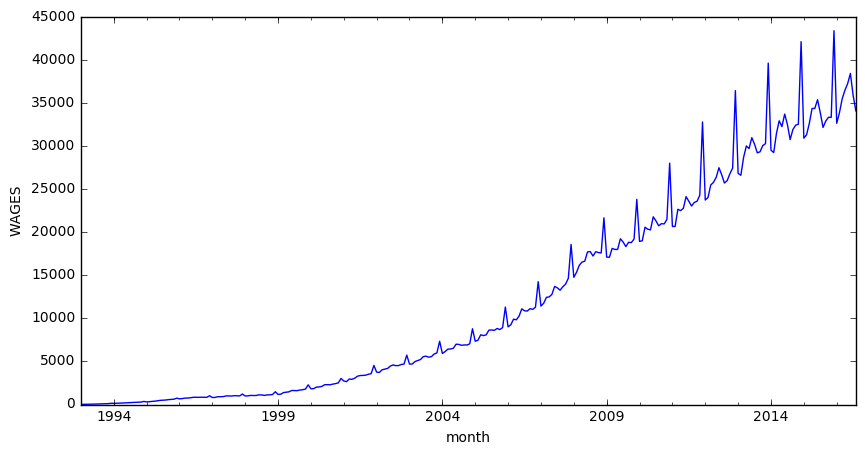

In [5]:
plt.figure(figsize(10,5))
data.WAG_C_M.plot()
plt.ylabel('WAGES')
plt.show()

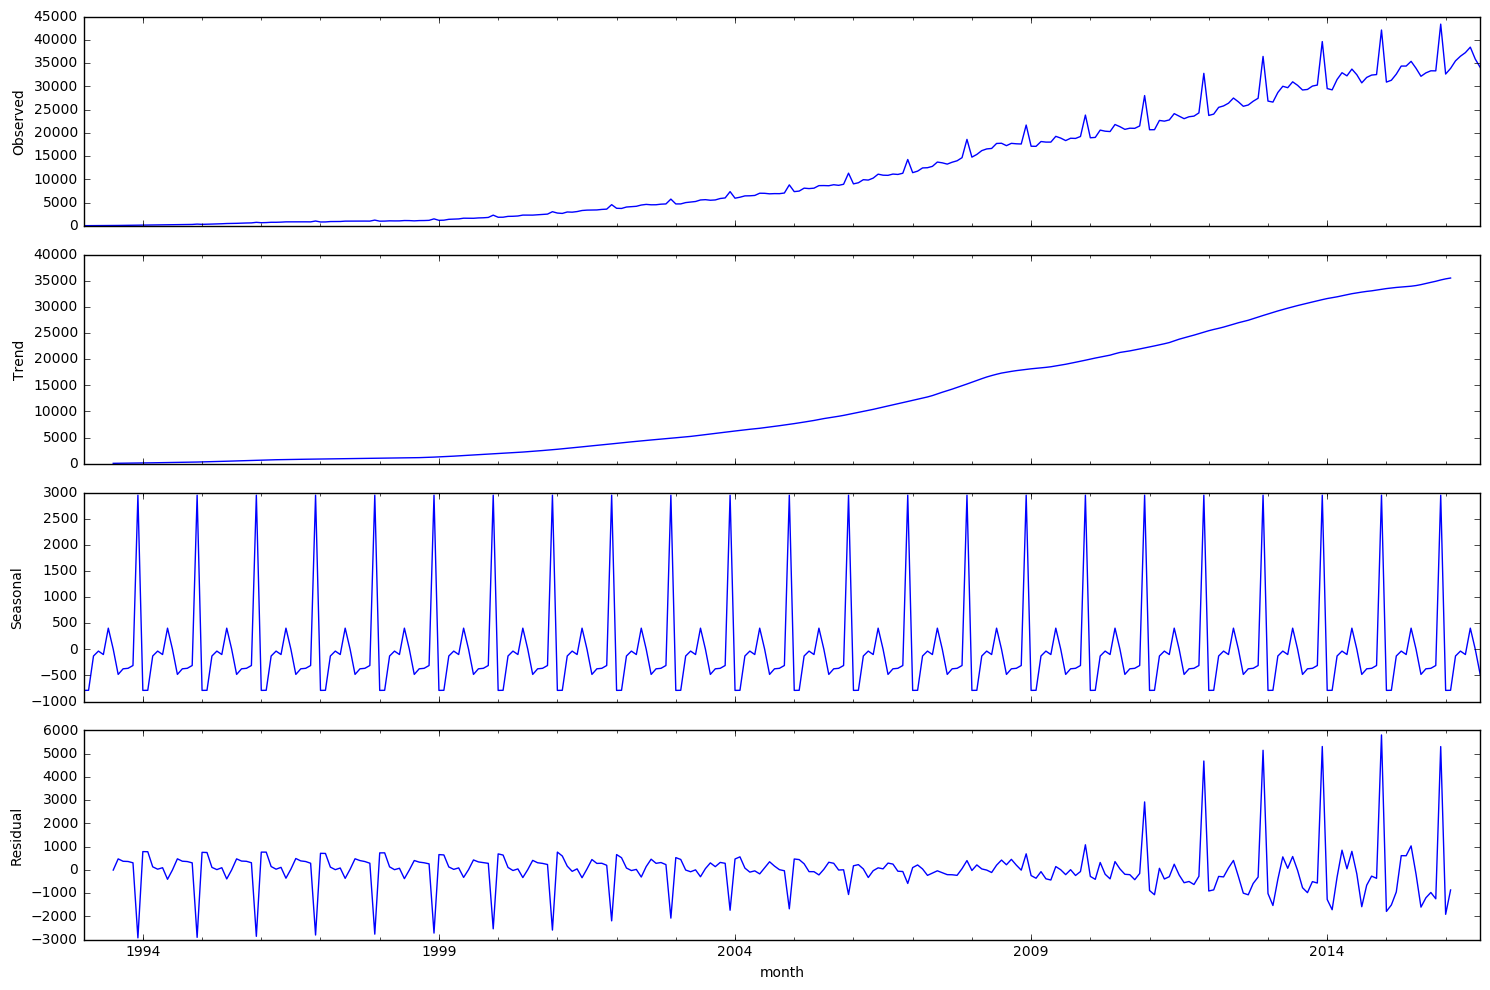

Dickey Fuller's criteria: p = 0.9918495954854734


In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()
print("Dickey Fuller's criteria: p = {}".format(sm.tsa.stattools.adfuller(data.WAG_C_M)[1]))

In [7]:
data['WAG_BOX'], lmbda = stats.boxcox(data.WAG_C_M)

In [8]:
print('lambda = {}'.format(lmbda))

lambda = 0.2632017541844584


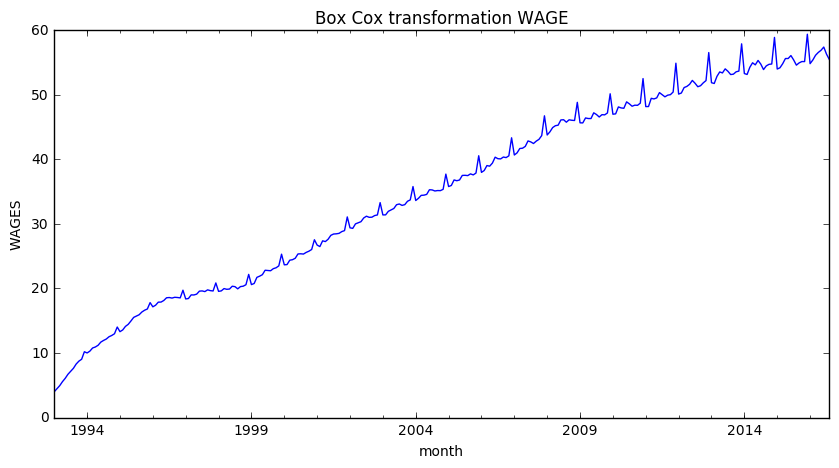

Dickey-Fuller's criteria: p = 0.696898763483267


In [9]:
plt.figure(figsize(10, 5))
data.WAG_BOX.plot()
plt.title('Box Cox transformation WAGE')
plt.ylabel('WAGES')
plt.show()
print("Dickey-Fuller's criteria: p = {}".format(sm.tsa.stattools.adfuller(data.WAG_BOX)[1]))

In [10]:
data['WAG_BOX_S_DIFFER'] = data.WAG_BOX - data.WAG_BOX.shift(12)

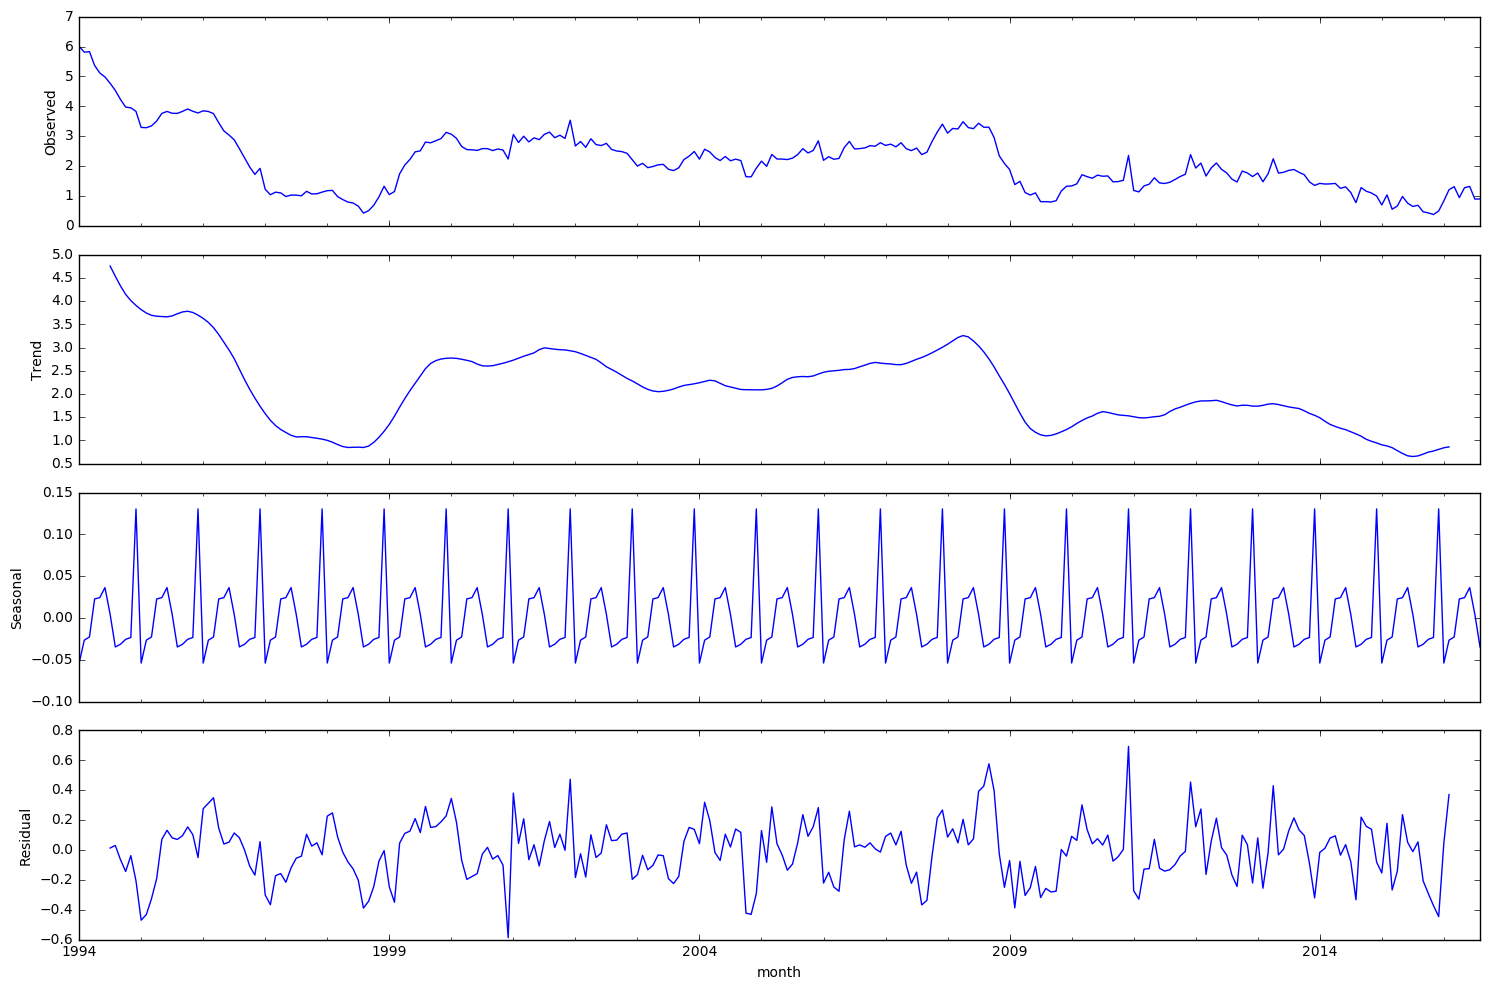

Dickey-Fuller's criteria: p = 0.014697133494791847


In [11]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_BOX_S_DIFFER[12:]).plot()
plt.show()
print("Dickey-Fuller's criteria: p = {}".format(sm.tsa.stattools.adfuller(data.WAG_BOX_S_DIFFER[12:])[1]))

In [12]:
data['WAG_BOX_S_C_DIFFER'] = data.WAG_BOX_S_DIFFER - data.WAG_BOX_S_DIFFER.shift(1)

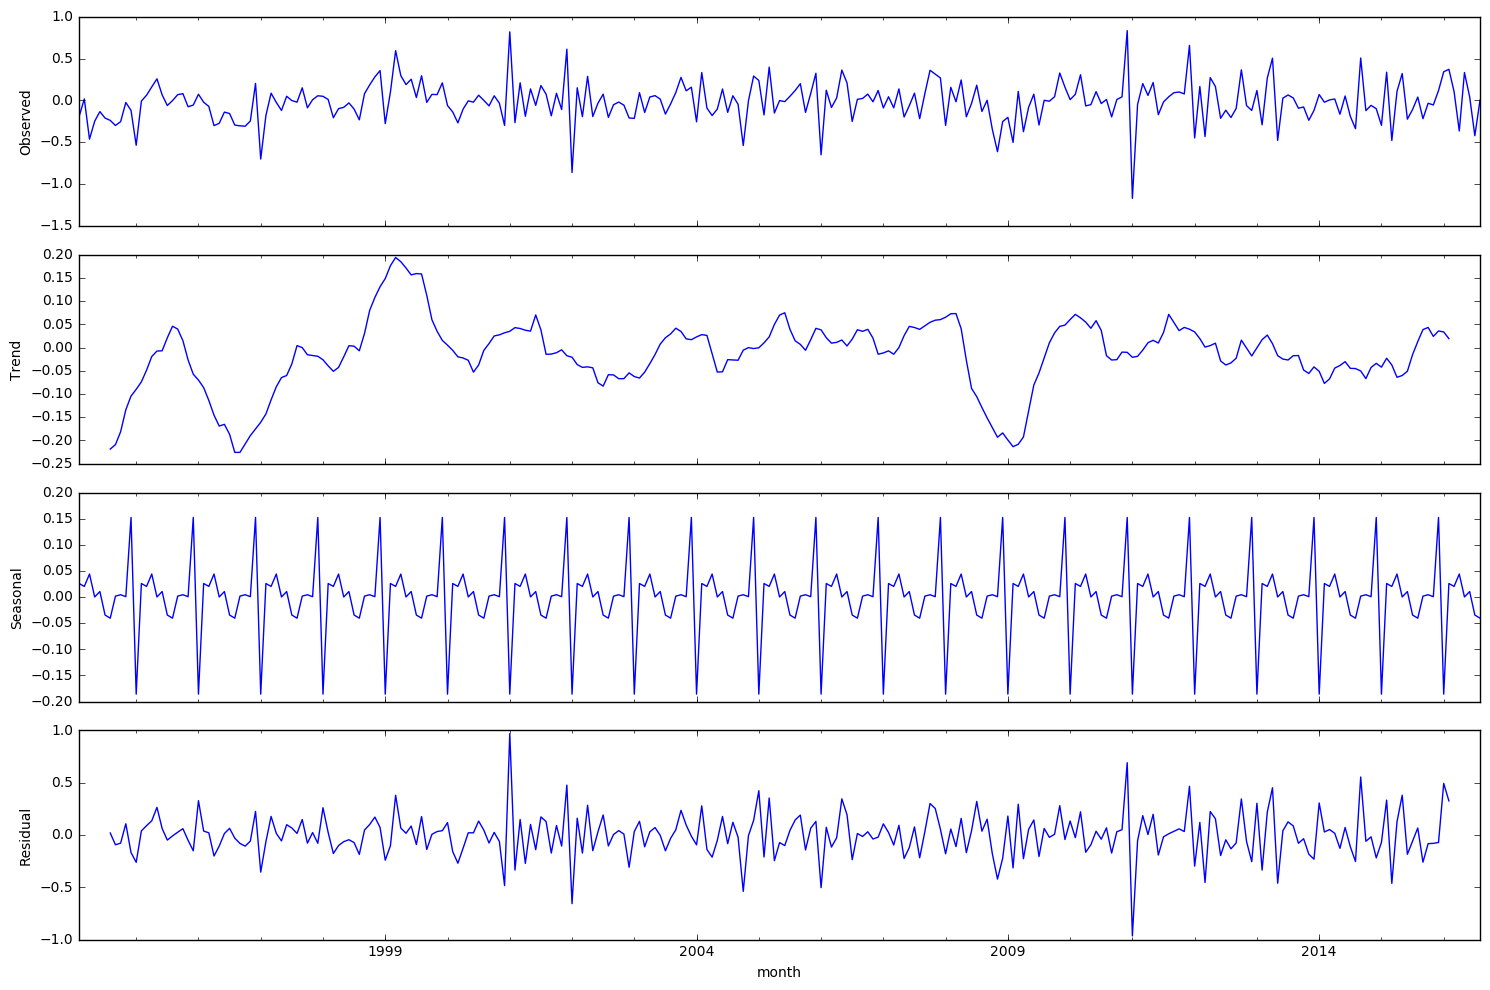

Dickey-Fuller's criteria: p = 5.203603715821792e-08


In [13]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_BOX_S_C_DIFFER[13:]).plot()
plt.show()
print("Dickey-Fuller's criteria: p = {}".format(sm.tsa.stattools.adfuller(data.WAG_BOX_S_C_DIFFER[13:])[1]))

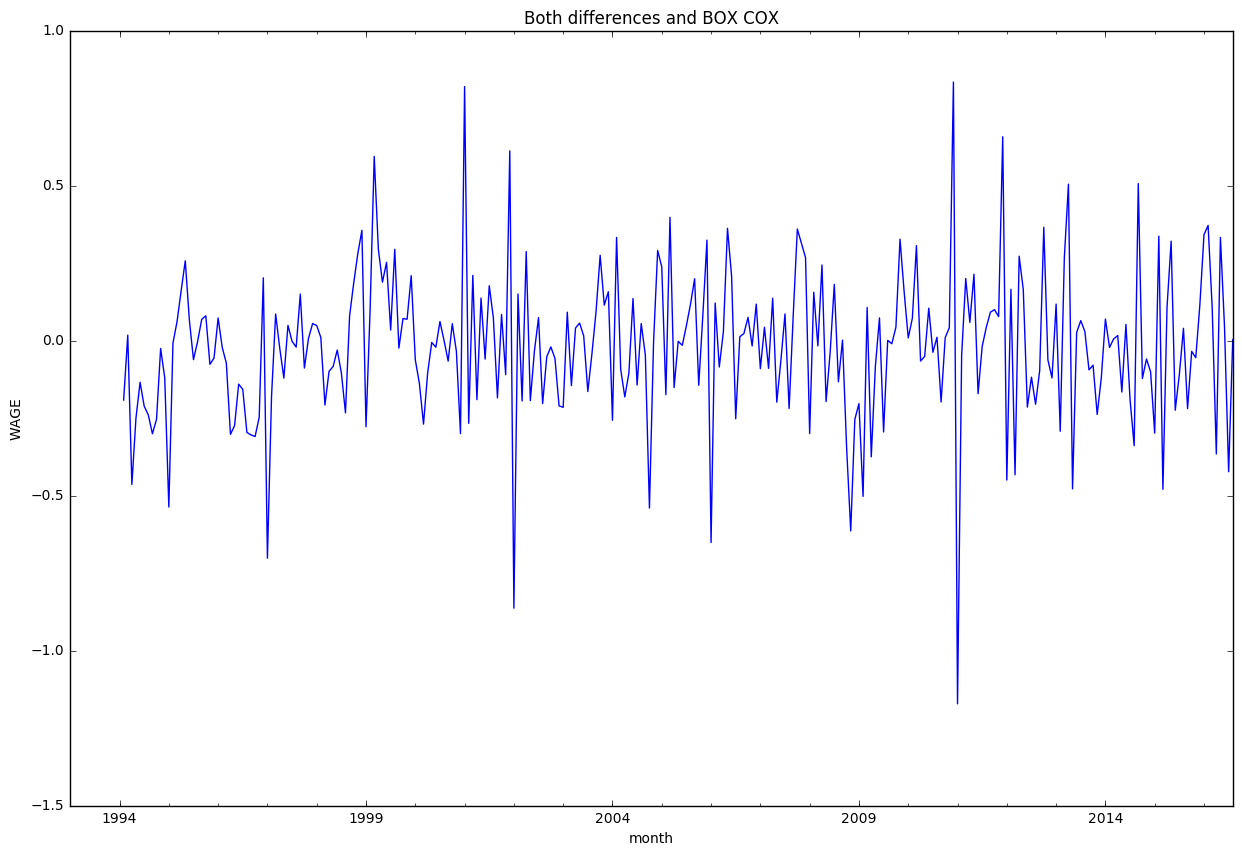

In [14]:
plt.figure(figsize(15,10))
data.WAG_BOX_S_C_DIFFER.plot()
plt.title('Both differences and BOX COX')
plt.ylabel('WAGE')
plt.show()

### Let's analyze partial autocorrelation and autocorrelation

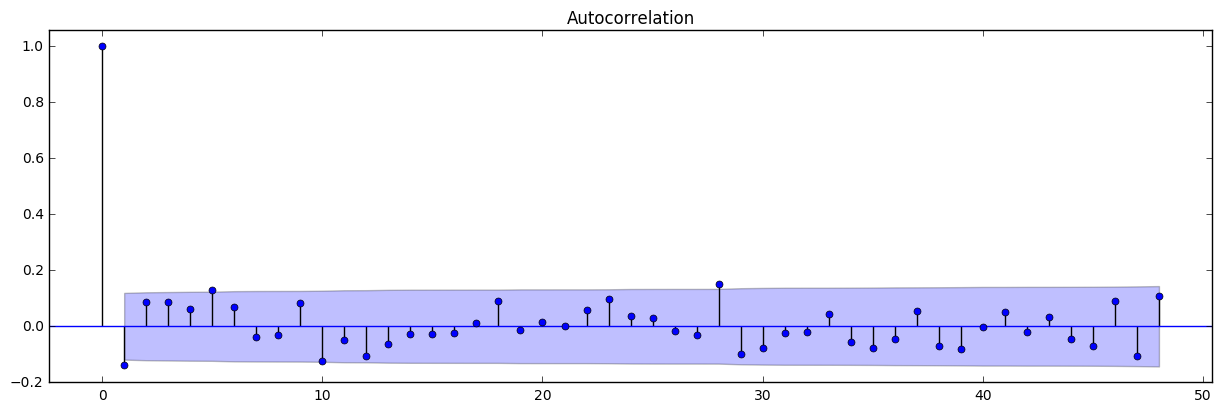

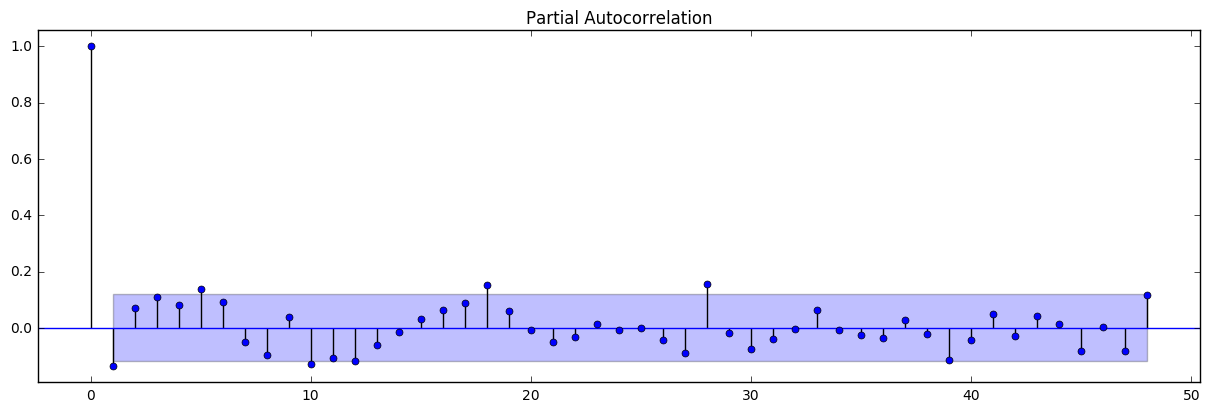

In [15]:
plt.figure(figsize(15, 10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_BOX_S_C_DIFFER[13:].values.squeeze(), lags = 48, ax =ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_BOX_S_C_DIFFER[13:].values.squeeze(), lags = 48, ax = ax)
pylab.show()

###### Начальные приближения: Q=0, q=1, P=1, p=1 D=1 d=1

In [16]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [17]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_BOX, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 2.73 s


In [19]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021912
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832


In [20]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_BOX   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Mon, 30 Apr 2018   AIC                              0.341
Time:                                    19:11:27   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

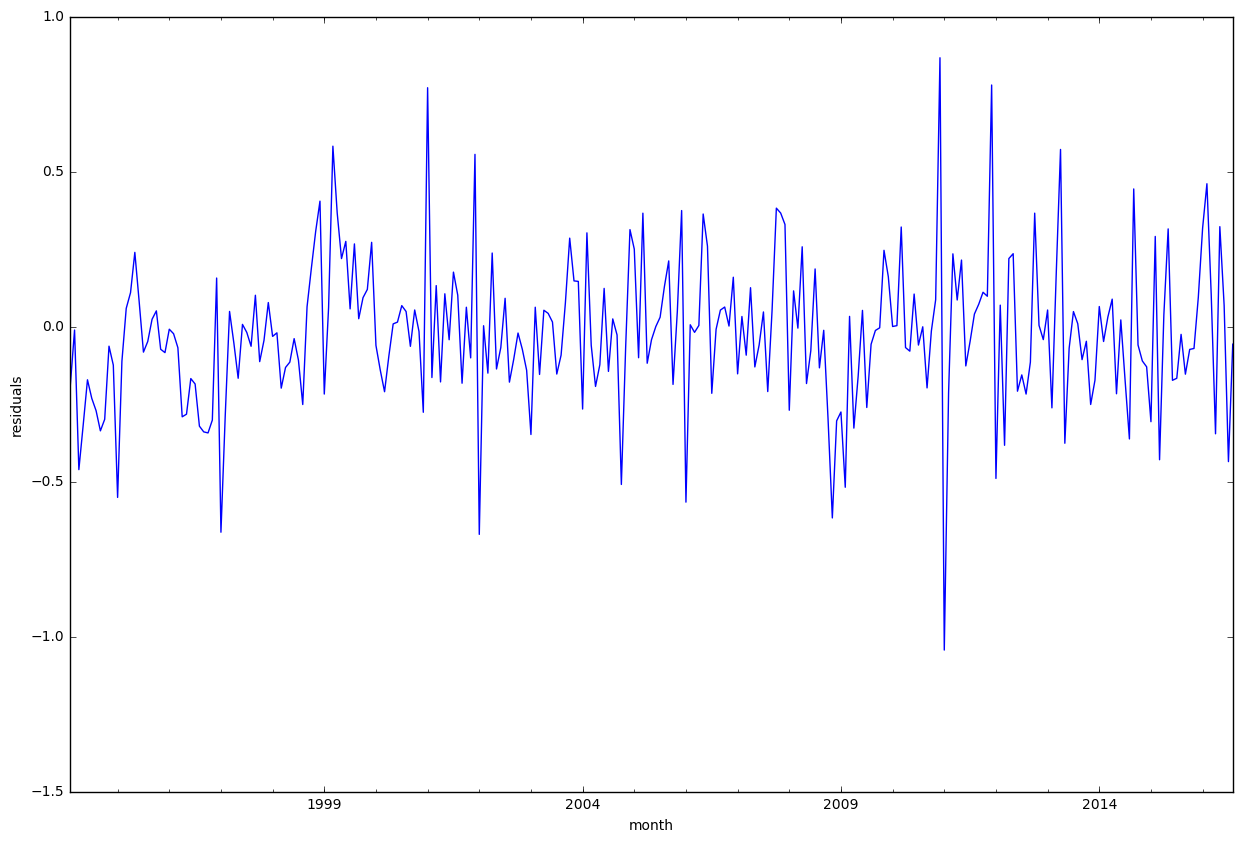

In [21]:
plt.figure(figsize(15,10))
best_model.resid[13:].plot()
plt.ylabel('residuals')
plt.show()

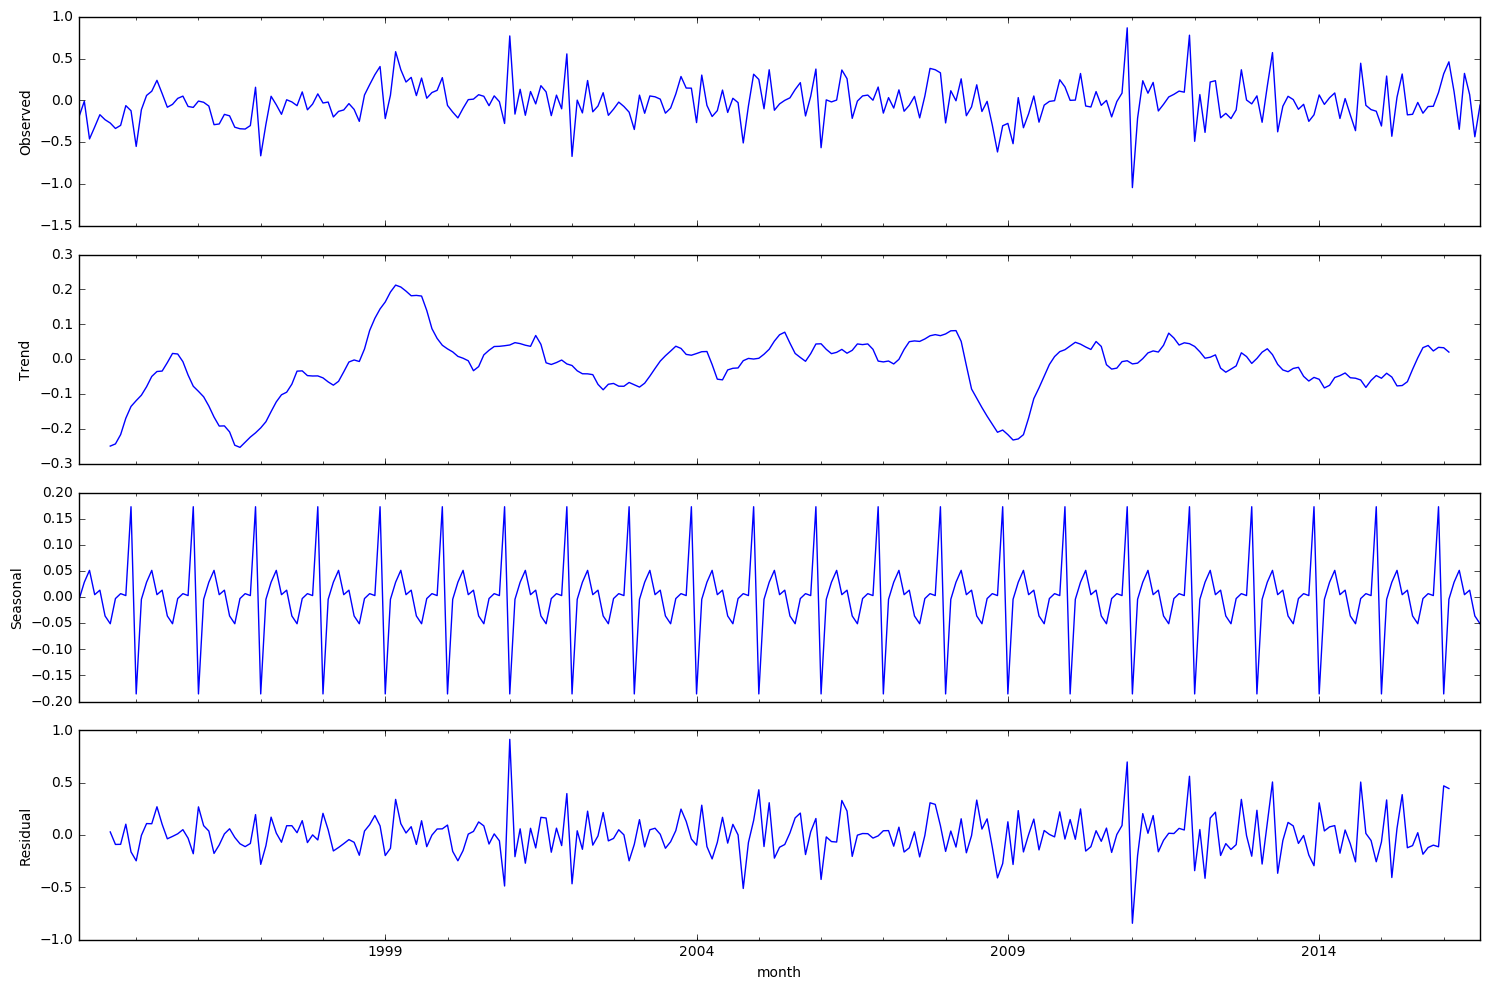

Dickey-Fuller's criteria: p = 3.459332603830631e-06
Критерий Стьюдента: p = 0.09079186725023848


In [22]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(best_model.resid[13:]).plot()
plt.show()
print("Dickey-Fuller's criteria: p = {}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))
print("Критерий Стьюдента: p = {}".format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))

In [23]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)

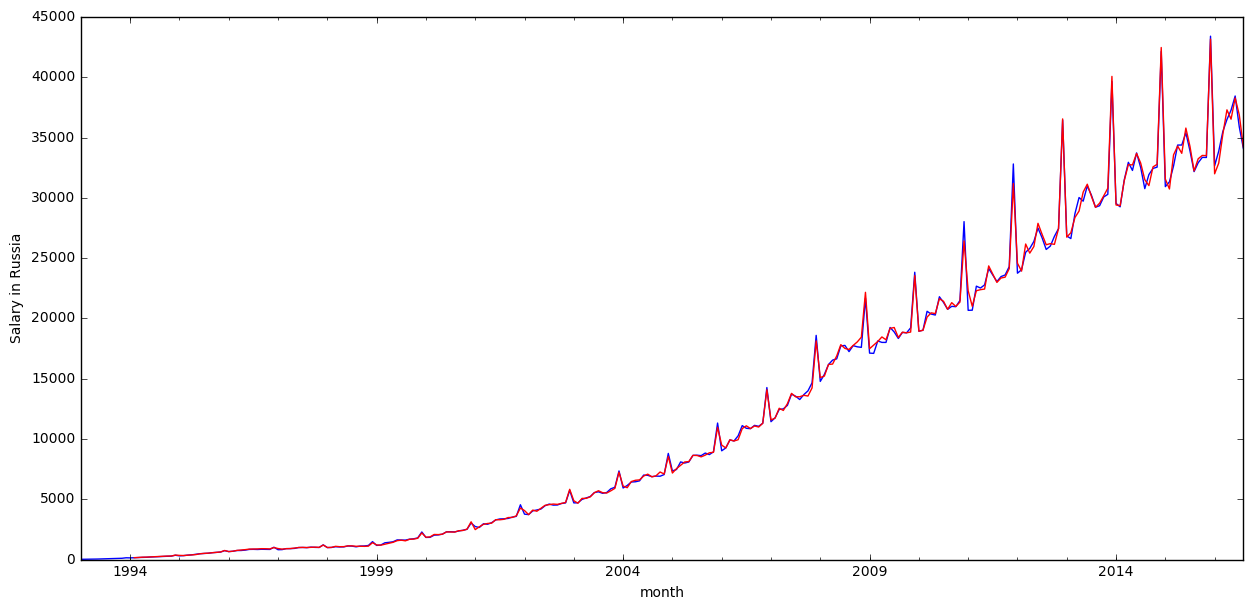

In [24]:
plt.figure(figsize(15,7))

data.WAG_C_M.plot(color = 'b')
data.model[13:].plot(color='r')
plt.ylabel('Salary in Russia')
pylab.show()

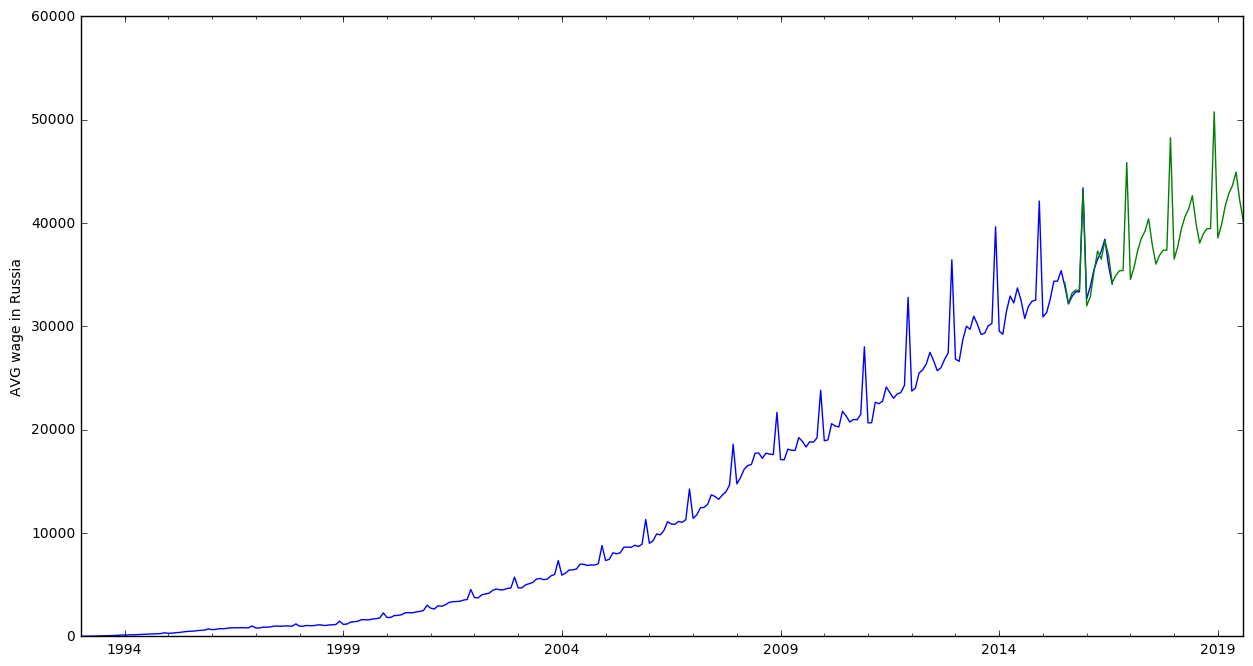

In [25]:
WAGE_2 = data[['WAG_C_M']]

date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months = x) for x in range (0,36)]
future = pd.DataFrame(index = date_list, columns = WAGE_2.columns)

WAGE_2 = pd.concat([WAGE_2, future])
WAGE_2['forecast'] = invboxcox(best_model.predict(start = 270, end = 325), lmbda)

plt.figure(figsize(15, 8))
WAGE_2.WAG_C_M.plot()
WAGE_2.forecast.plot(color = 'green')
plt.ylabel('AVG wage in Russia')
pylab.show()

In [26]:
data.shape

(284, 5)

In [27]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, median_absolute_error as mdae, r2_score

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mean_absolute_percentage_error(WAGE_2.WAG_C_M[270:284], WAGE_2.forecast[270:284]), mae(WAGE_2.WAG_C_M[270:284], WAGE_2.forecast[270:284]) 

(1.2237284426908457, 430.54899158756547)